In [ ]:
#Setup

In [52]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

In [53]:
#Data Loading

In [54]:
df = pd.read_csv('GOOG.csv')

In [55]:
#Data

In [56]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-01-03,10.523555,10.851077,10.416457,10.840119,10.840119,526815259
1,2006-01-04,11.056059,11.182087,10.952697,11.089434,11.089434,613747887
2,2006-01-05,11.108363,11.246595,10.996283,11.238874,11.238874,433952486
3,2006-01-06,11.379098,11.718576,11.288687,11.598028,11.598028,712938289
4,2006-01-09,11.616708,11.790805,11.480468,11.628912,11.628912,513593887


In [57]:
# Extract "Date" and "Close" feature colums from the dataframe

In [58]:
df = df[['Date', 'Close']]

In [59]:
# Concise summary of a DataFrame

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3775 entries, 0 to 3774
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3775 non-null   object 
 1   Close   3775 non-null   float64
dtypes: float64(1), object(1)
memory usage: 59.1+ KB


In [61]:
#Data Time Period

In [62]:
df['Date'].min(), df['Date'].max()

('2006-01-03', '2020-12-30')

In [63]:
#visualize the data

In [64]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='Graph Variation 2010-2020')
fig.show()

In [65]:
#Data Preprocessing

In [66]:
#1. Train - test split

In [67]:
train = df.loc[df['Date'] <= '2017-12-24']
test = df.loc[df['Date'] > '2017-12-24']
train.shape, test.shape

((3016, 2), (759, 2))

In [68]:
#2. Data Scaling

In [69]:
scaler = StandardScaler()
scaler.fit(train[['Close']])

train.loc[:, 'Close'] = scaler.transform(train[['Close']])
test.loc[:, 'Close'] = scaler.transform(test[['Close']])

In [70]:
# Visualize scaled data

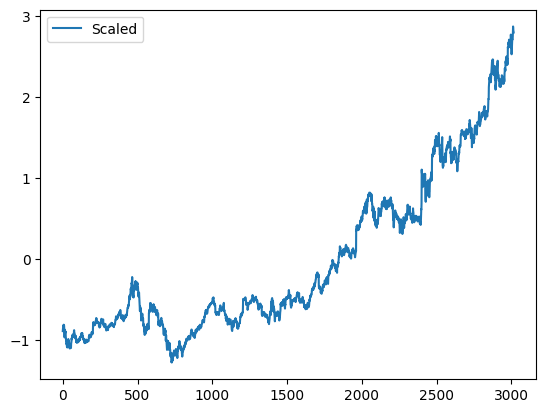

In [71]:
plt.plot(train['Close'], label = 'Scaled')
plt.legend()
plt.show()

In [72]:
#creating Sequence

In [73]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])
    
    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (2986, 30, 1)
Testing input shape:  (729, 30, 1)


In [74]:
X_train[2985]

array([[2.67190694],
       [2.65794147],
       [2.64778458],
       [2.64887914],
       [2.62659593],
       [2.67733553],
       [2.61862782],
       [2.6155196 ],
       [2.68604745],
       [2.69248304],
       [2.71284015],
       [2.77237948],
       [2.74260981],
       [2.62987918],
       [2.62878462],
       [2.57957711],
       [2.52927504],
       [2.55760018],
       [2.6155196 ],
       [2.67046233],
       [2.69725503],
       [2.7149854 ],
       [2.71227093],
       [2.71284015],
       [2.75022743],
       [2.81607084],
       [2.87276446],
       [2.84448345],
       [2.81939822],
       [2.81361923]])

In [75]:
# set seed to regenerate same sequence of random numbers. 

In [76]:
np.random.seed(21)
tf.random.set_seed(21)

In [77]:
#Building Model

In [78]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_1 (RepeatVec  (None, 30, 128)           0         
 tor)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_1 (TimeDi  (None, 30, 1)             129       
 stributed)                                           

In [79]:
#train Model

In [80]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100
84/84 [==============================] - 17s 87ms/step - loss: 0.0675 - val_loss: 0.1254
Epoch 2/100
84/84 [==============================] - 6s 66ms/step - loss: 0.0295 - val_loss: 0.0598
Epoch 3/100
84/84 [==============================] - 5s 64ms/step - loss: 0.0227 - val_loss: 0.0403
Epoch 4/100
84/84 [==============================] - 5s 64ms/step - loss: 0.0205 - val_loss: 0.0318
Epoch 5/100
84/84 [==============================] - 5s 65ms/step - loss: 0.0178 - val_loss: 0.0249
Epoch 6/100
84/84 [==============================] - 5s 64ms/step - loss: 0.0160 - val_loss: 0.0218
Epoch 7/100
84/84 [==============================] - 5s 64ms/step - loss: 0.0156 - val_loss: 0.0213
Epoch 8/100
84/84 [==============================] - 5s 64ms/step - loss: 0.0142 - val_loss: 0.0250
Epoch 9/100
84/84 [==============================] - 5s 60ms/step - loss: 0.0133 - val_loss: 0.0171
Epoch 10/100
84/84 [==============================] - 3s 41ms/step - loss: 0.0159 - val_loss: 0.023

In [29]:
#Plot Training - Validation loss

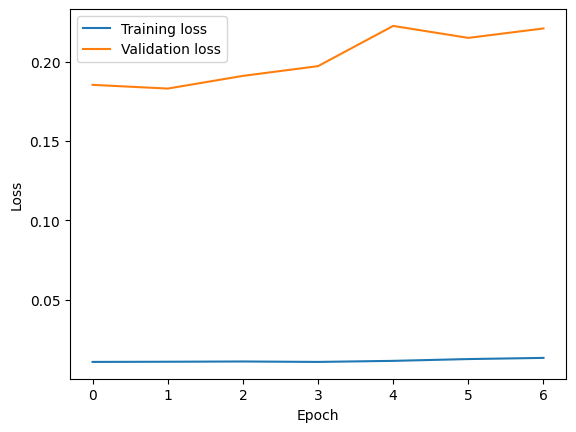

In [43]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

In [58]:
# Mean Absolute Error loss

94/94 [==============================] - 2s 22ms/step
Reconstruction error threshold: 0.8263905347180691


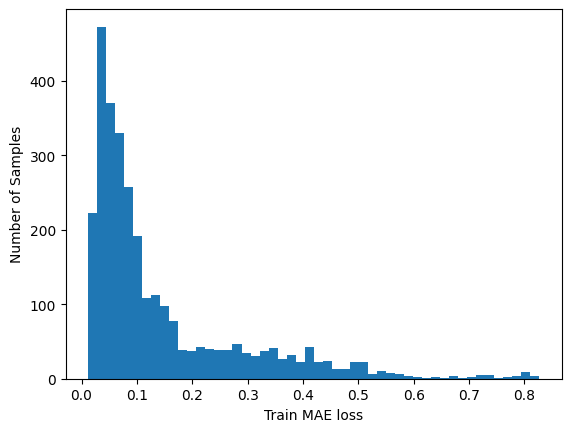

In [44]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

In [33]:
#Reconstruction error threshold: 0.40592592538097727

In [34]:
#Predict Anomalies on test data using threshold

23/23 [==============================] - 1s 22ms/step


Text(0, 0.5, 'Number of samples')

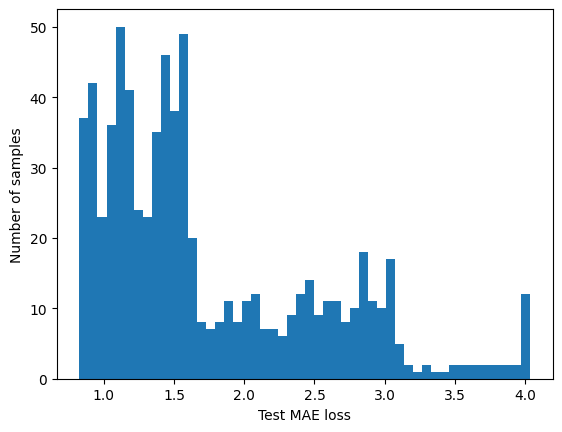

In [45]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [46]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [47]:
anomaly_df.head()

,Date,Close,loss,threshold,anomaly
3046,2018-02-08,2.541708,1.167985,0.826391,True
3047,2018-02-09,2.700451,1.179760,0.826391,True
3048,2018-02-12,2.762442,1.169118,0.826391,True
3049,2018-02-13,2.763142,1.164829,0.826391,True
3050,2018-02-14,2.840193,1.165006,0.826391,True


In [48]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [49]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
3046,2018-02-08,2.541708,1.167985,0.826391,True
3047,2018-02-09,2.700451,1.179760,0.826391,True
3048,2018-02-12,2.762442,1.169118,0.826391,True
3049,2018-02-13,2.763142,1.164829,0.826391,True
3050,2018-02-14,2.840193,1.165006,0.826391,True


In [50]:
anomalies.shape

(729, 5)

In [51]:
close_prices = anomaly_df['Close'].values.reshape(-1, 1)

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['Date'], y=scaler.inverse_transform(close_prices).flatten(), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies[['Close']]).flatten(), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()